In [1]:
import pandas as pd
from pandas.io.gbq import read_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

## The general challenge is to look at how extreme weather affects 311 service requests: First we have to define and identify extreme weather. Second we have to look how extreme weather events affect 311 request types and volume. Lastly, can we predict call/complaint volume for extreme weather events such as high/low temperature, snow, rain etc. ?

In [2]:
#let's look at the data! start with weather data: pull for 2010-2017 for the central park station
query = "SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as created_date, temp, wdsp, mxpsd, gust, max, min, prcp, sndp, snow_ice_pellets FROM `bigquery-public-data.noaa_gsod.gsod20*` WHERE _TABLE_SUFFIX BETWEEN '10' AND '17' AND stn = '725053' AND wban = '94728'"
weather = read_gbq(query=query, project_id='opendataproject-180502', dialect='standard')

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 879, in _find_spec
AttributeError: 'PyxImporter' object has no attribute 'find_spec'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load
  File "<frozen importlib._bootstrap>", line 946, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 881, in _find_spec
  File "<frozen importlib._bootstrap>", line 855, in _find_spec_legacy
  File "/anaconda/lib/python3.6/site-packages/pyximport/pyximport.py", line 254, in find_module
    fp, pathname, (ext,mode,ty) = imp.find_module(fullname,package_path)
  File "/anaconda/lib/python3.6/imp.py", line 270, in find_module
    "not {}".format(type(path)))
RuntimeError: 'path' 

Requesting query... 

INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/jobs?alt=json


ok.
Query running...


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/queries/job_u68gfcBtHJakUMQQ0r9IBN5DLtNm?alt=json


Query done.
Processed: 2.6 Gb

Retrieving results...
Got 1727 rows.

Total time taken 2.93 s.
Finished at 2017-09-24 13:13:01.


In [3]:
pd.set_option("display.max_columns",1001)

In [4]:
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
0,2015-12-25,62.0,0.7,4.1,999.9,72.0,57.0,0.01,999.9,0
1,2017-09-12,69.0,0.8,4.1,999.9,78.1,55.0,0.00,999.9,0
2,2015-09-06,74.1,1.0,4.1,999.9,87.1,64.9,0.00,999.9,0
3,2015-09-16,75.8,1.5,4.1,999.9,88.0,62.1,0.00,999.9,0
4,2013-08-17,72.6,1.6,4.1,999.9,84.0,64.0,0.00,999.9,0


In [5]:
#do some aggregating for simplicty
query = """SELECT DATE(created_date) AS `created_date`, complaint_type, count(unique_key) AS `count_n`
FROM `bigquery-public-data.new_york.311_service_requests`
GROUP BY DATE(created_date), complaint_type"""
dfcounts = read_gbq(query=query, project_id='opendataproject-180502', dialect='standard')

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 879, in _find_spec
AttributeError: 'PyxImporter' object has no attribute 'find_spec'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load
  File "<frozen importlib._bootstrap>", line 946, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 881, in _find_spec
  File "<frozen importlib._bootstrap>", line 855, in _find_spec_legacy
  File "/anaconda/lib/python3.6/site-packages/pyximport/pyximport.py", line 254, in find_module
    fp, pathname, (ext,mode,ty) = imp.find_module(fullname,package_path)
  File "/anaconda/lib/python3.6/imp.py", line 270, in find_module
    "not {}".format(type(path)))
RuntimeError: 'path' 

Requesting query... 

INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/jobs?alt=json


ok.
Query running...


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/queries/job_R5qw-hWVjk-6Iq6GPS4aiiwSTCpN?alt=json


Query done.
Processed: 518.0 Mb

Retrieving results...
  Got page: 1; 28% done. Elapsed 14.27 s.


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/queries/job_R5qw-hWVjk-6Iq6GPS4aiiwSTCpN?pageToken=BGRIX25ULYAQAAASA4EAAEEAQCAAKGQIBCQI2BQQUCGQMIFQVYKQ%3D%3D%3D%3D&alt=json


  Got page: 2; 55% done. Elapsed 19.18 s.


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/queries/job_R5qw-hWVjk-6Iq6GPS4aiiwSTCpN?pageToken=BGRIX25ULYAQAAASA4EAAEEAQCAAKGQIBDAJUDAQUCGQMIFQVYKQ%3D%3D%3D%3D&alt=json


  Got page: 3; 83% done. Elapsed 25.05 s.


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/queries/job_R5qw-hWVjk-6Iq6GPS4aiiwSTCpN?pageToken=BGRIX25ULYAQAAASA4EAAEEAQCAAKGQIBDQKOEQQUCGQMIFQVYKQ%3D%3D%3D%3D&alt=json


  Got page: 4; 100% done. Elapsed 27.9 s.
Got 362324 rows.

Total time taken 29.98 s.
Finished at 2017-09-24 13:25:12.


In [6]:
dfcounts.head()

,created_date,complaint_type,count_n
0,2013-08-29,Noise - Commercial,61
1,2011-10-31,Noise - Commercial,61
2,2012-12-29,Noise - Commercial,61
3,2016-12-27,Noise - Commercial,61
4,2010-07-11,Noise - Commercial,61


In [7]:
dfcounts.sort_values(['created_date'], ascending = 0).head()

,created_date,complaint_type,count_n
139595,2017-09-23,Noise - Vehicle,41
204652,2017-09-23,Street Light Condition,5
123205,2017-09-23,Illegal Parking,31
265604,2017-09-23,Smoking,1
294800,2017-09-23,Opinion for the Mayor,1


In [8]:
#look at total counts per day over time relative to temperature
query = """SELECT DATE(created_date) AS `created_date`, count(unique_key) AS count_n
            FROM `bigquery-public-data.new_york.311_service_requests`
           GROUP BY DATE(created_date)"""
dfdaycounts = read_gbq(query=query, project_id='opendataproject-180502', dialect='standard')

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 879, in _find_spec
AttributeError: 'PyxImporter' object has no attribute 'find_spec'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load
  File "<frozen importlib._bootstrap>", line 946, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 881, in _find_spec
  File "<frozen importlib._bootstrap>", line 855, in _find_spec_legacy
  File "/anaconda/lib/python3.6/site-packages/pyximport/pyximport.py", line 254, in find_module
    fp, pathname, (ext,mode,ty) = imp.find_module(fullname,package_path)
  File "/anaconda/lib/python3.6/imp.py", line 270, in find_module
    "not {}".format(type(path)))
RuntimeError: 'path' 

Requesting query... 

INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/jobs?alt=json


ok.
Query running...


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/opendataproject-180502/queries/job_5eavSiWnA2iaMLNEUgmDg5JKNLIc?alt=json


Query done.
Processed: 245.4 Mb

Retrieving results...
Got 2823 rows.

Total time taken 3.37 s.
Finished at 2017-09-24 13:25:17.


In [9]:
dfdaycounts.head()

,created_date,count_n
0,2011-10-01,3072
1,2011-11-20,3072
2,2014-03-02,4096
3,2014-07-27,4096
4,2012-07-20,4608


In [10]:
dfdaycounts['created_date'] = pd.to_datetime(dfdaycounts['created_date'], errors = 'coerce')

In [11]:
dfdaycounts = dfdaycounts.sort_values(['created_date'])

(array([ 733773.,  734138.,  734503.,  734869.,  735234.,  735599.,
         735964.,  736330.]), <a list of 8 Text xticklabel objects>)

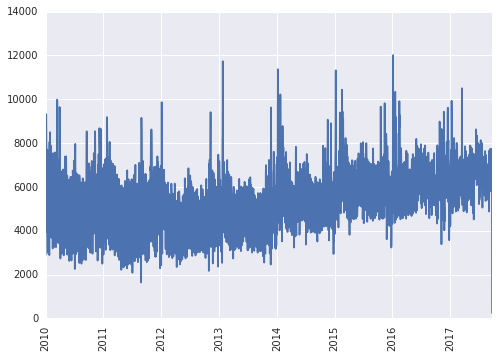

In [22]:
plt.plot(dfdaycounts['created_date'], dfdaycounts['count_n'])
plt.xticks(rotation='vertical')

In [12]:
weather['created_date'] = pd.to_datetime(weather['created_date'], errors = 'coerce')

In [13]:
weather = weather.sort_values(by='created_date')
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
981,2013-01-01,37.8,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0
1108,2013-01-02,27.1,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0
593,2013-01-03,28.4,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0
1480,2013-01-04,33.4,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0
1412,2013-01-05,36.1,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0


(array([ 734959.,  735142.,  735324.,  735507.,  735689.,  735872.,
         736055.,  736238.,  736420.]), <a list of 9 Text xticklabel objects>)

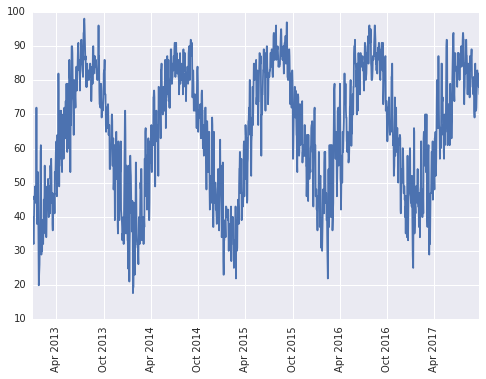

In [37]:
#let's look at temperature across time by max temperature
plt.plot(weather['created_date'], weather['max'])
plt.xticks(rotation='vertical')

In [44]:
#this weather station started in 2013
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
980,2013-01-01,37.8,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0
1105,2013-01-02,27.1,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0
600,2013-01-03,28.4,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0
1479,2013-01-04,33.4,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0
1412,2013-01-05,36.1,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0


In [14]:
#so for now filtering 311 data to 2013 and after
dfrecent = dfdaycounts[dfdaycounts['created_date']> pd.to_datetime('2012-12-31')]

In [15]:
dfrecent.head()

,created_date,count_n
33,2013-01-01,3331
18,2013-01-02,7169
985,2013-01-03,6742
2193,2013-01-04,6085
2028,2013-01-05,4024


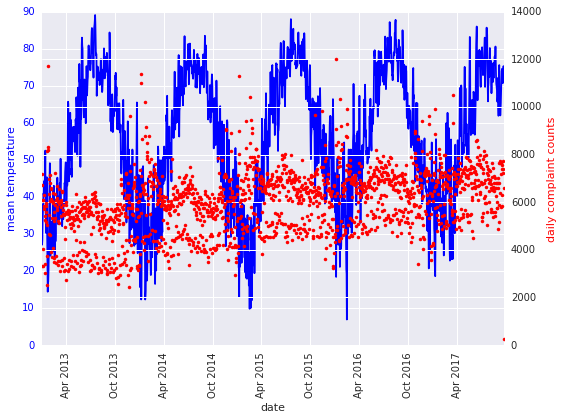

In [68]:
#look at overlay of counts of complaints/day and temperature

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(weather['created_date'], weather['temp'], 'b-')
ax1.set_xlabel('date')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('mean temperature', color='b')
ax1.tick_params('y', colors='b')
plt.xticks(rotation='vertical')
ax2 = ax1.twinx()

ax2.plot(dfrecent['created_date'], dfrecent['count_n'], 'r.')
ax2.set_ylabel('daily complaint counts', color='r')
ax2.tick_params('mean daily temperature', colors='r')

fig.tight_layout()
plt.show()
fig.savefig('counts_and_temp.png', dpi = 300)

In [62]:
#looks like the days with the most complaints often fall in the winter. 
#take a closer look at the dates and the weather

In [19]:

dfrecent.sort_values(by = 'count_n', ascending = 0, inplace = True)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
dfrecent.head(10) #looks like mainly winter days have the highest counts

,created_date,count_n
2643,2016-01-05,12012
2378,2013-01-24,11732
1176,2014-01-07,11367
600,2015-01-08,11318
2747,2014-01-08,10998
62,2017-03-15,10501
2158,2015-02-16,10434
1121,2016-01-19,10338
2633,2014-01-23,10219
2237,2017-01-09,9928


In [16]:
dfcounts['created_date'] = pd.to_datetime(dfcounts['created_date'])
dfrecent['created_date'] = pd.to_datetime(dfrecent['created_date'])

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
#join in the weather for these days! then look at complaint types
dfjoined = dfrecent.merge(dfcounts, how = 'inner', on = ['created_date'])

In [21]:
dfjoined.columns = [['created_date', 'count_complaints_day','complaint_type', 'count_type_day']]

In [22]:
dfjoined.sort_values(['count_type_day'], ascending = 0).head()

,created_date,count_complaints_day,complaint_type,count_type_day
2770,2013-01-24,11732,HEATING,5847
147676,2016-02-14,9907,HEAT/HOT WATER,5798
93613,2015-01-08,11318,HEAT/HOT WATER,5278
45887,2014-01-07,11367,HEATING,5089
142369,2016-01-05,12012,HEAT/HOT WATER,5053


In [23]:
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
981,2013-01-01,37.8,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0
1108,2013-01-02,27.1,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0
593,2013-01-03,28.4,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0
1480,2013-01-04,33.4,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0
1412,2013-01-05,36.1,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0


In [24]:
dfjoined = dfjoined.merge(weather, on = ['created_date'], how = 'left')

In [25]:
dfjoined.sort_values(['count_type_day'], ascending = 0).head()#very cold days have heat complaints

,created_date,count_complaints_day,complaint_type,count_type_day,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
2770,2013-01-24,11732,HEATING,5847,16.8,6.7,15.0,27.0,21.9,12.0,0.00,999.9,0
147676,2016-02-14,9907,HEAT/HOT WATER,5798,6.9,7.6,14.0,31.1,21.9,-0.9,0.00,999.9,0
93613,2015-01-08,11318,HEAT/HOT WATER,5278,13.0,8.8,18.1,31.1,23.0,8.1,0.00,1.2,0
45887,2014-01-07,11367,HEATING,5089,12.3,13.0,19.0,31.1,36.0,3.9,0.27,1.2,0
142369,2016-01-05,12012,HEAT/HOT WATER,5053,18.4,6.2,12.0,22.0,36.0,10.9,0.00,999.9,0


In [29]:
#sort by top complaints and top complaint type
dfjoined.sort_values(['count_complaints_day', 'count_type_day'], ascending = [0,0], inplace = True)

In [30]:
dfjoined.head()

,created_date,count_complaints_day,complaint_type,count_type_day,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
142369,2016-01-05,12012,HEAT/HOT WATER,5053,18.4,6.2,12.0,22.0,36.0,10.9,0.0,999.9,0
142367,2016-01-05,12012,Street Light Condition,409,18.4,6.2,12.0,22.0,36.0,10.9,0.0,999.9,0
142365,2016-01-05,12012,UNSANITARY CONDITION,404,18.4,6.2,12.0,22.0,36.0,10.9,0.0,999.9,0
142360,2016-01-05,12012,PLUMBING,363,18.4,6.2,12.0,22.0,36.0,10.9,0.0,999.9,0
142356,2016-01-05,12012,PAINT/PLASTER,344,18.4,6.2,12.0,22.0,36.0,10.9,0.0,999.9,0


In [31]:
#take the top complaint type per day
dftopcomplaint = dfjoined.groupby('created_date').first().reset_index()

In [32]:
dftopcomplaint.sort_values(['count_complaints_day'], ascending = 0, inplace = True)

In [33]:
dftop = dftopcomplaint[dftopcomplaint['count_complaints_day']> 7000]

In [34]:
len(dftop)


360

In [35]:
dftop.head()

,created_date,count_complaints_day,complaint_type,count_type_day,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
1099,2016-01-05,12012,HEAT/HOT WATER,5053,18.4,6.2,12.0,22.0,36.0,10.9,0.00,999.9,0
23,2013-01-24,11732,HEATING,5847,16.8,6.7,15.0,27.0,21.9,12.0,0.00,999.9,0
371,2014-01-07,11367,HEATING,5089,12.3,13.0,19.0,31.1,36.0,3.9,0.27,1.2,0
737,2015-01-08,11318,HEAT/HOT WATER,5278,13.0,8.8,18.1,31.1,23.0,8.1,0.00,1.2,0
372,2014-01-08,10998,HEATING,4048,12.9,6.3,11.1,20.0,21.0,9.0,0.00,999.9,0


In [36]:
dftop2 = dftop.groupby(['complaint_type']).size().reset_index(name = 'days_top_complaint')

In [37]:
dftop2.sort_values(['days_top_complaint'], ascending = 0, inplace = True)

In [38]:
#on how many of the high volume days were each of these the top complaints?
dftop2.head()

,complaint_type,days_top_complaint
2,HEAT/HOT WATER,144
4,Illegal Parking,46
6,Noise - Residential,36
10,Street Condition,36
3,HEATING,35


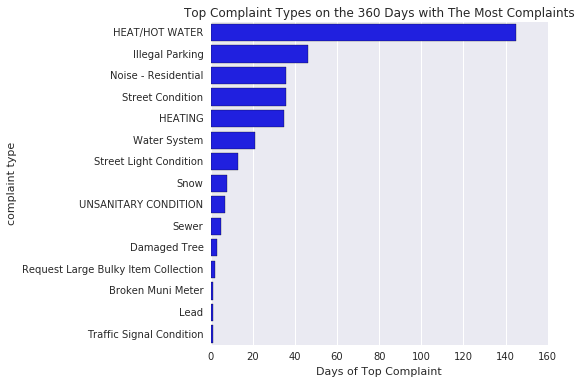

In [151]:

g = sns.plt.title('Top Complaint Types on the 360 Days with The Most Complaints')
g = sns.barplot(x = 'days_top_complaint', y='complaint_type', data = dftop2, color = "b" )
g.set(xlabel='Days of Top Complaint', ylabel='complaint type')
plt.tight_layout()
plt.savefig('Top_complaints_days_most_volume.png')

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


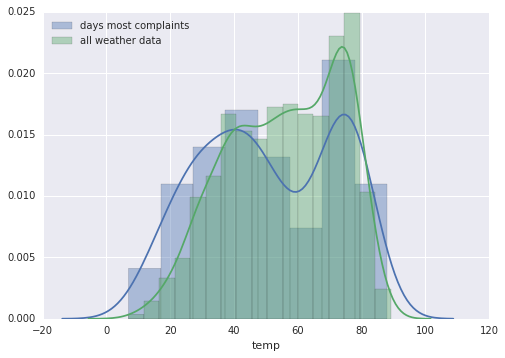

In [166]:
#compare distribution of temp for high volumne days versus all weather
g = sns.distplot(dftop['temp'], label = "days most complaints")
g = sns.distplot(weather['temp'], label = "all weather data")
g.legend(loc='upper left')
plt.savefig('Top_complaints_days_temp_dist_versus_all_data.png')

In [186]:
import scipy.stats as stats
#try two sample t test to see if the means of these distributions differ
t_stat, p_val = stats.ttest_ind(dftop['temp'],weather['temp'], equal_var=False)

In [187]:
t_stat

-4.1419800845579013

In [188]:
p_val

4.0872575947751864e-05

In [190]:
dftop['temp'].mean()

51.079999999999998

In [191]:
weather['temp'].mean()

56.031865585168021

## look at correlation of various aspects of weather data and complaint volume

In [41]:
weather_counts = dfrecent.merge(weather, on = ['created_date'], how = 'inner')

In [42]:
weather_counts.head()

,created_date,count_n,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
0,2016-01-05,12012,18.4,6.2,12.0,22.0,36.0,10.9,0.00,999.9,0
1,2013-01-24,11732,16.8,6.7,15.0,27.0,21.9,12.0,0.00,999.9,0
2,2014-01-07,11367,12.3,13.0,19.0,31.1,36.0,3.9,0.27,1.2,0
3,2015-01-08,11318,13.0,8.8,18.1,31.1,23.0,8.1,0.00,1.2,0
4,2014-01-08,10998,12.9,6.3,11.1,20.0,21.0,9.0,0.00,999.9,0


In [45]:
#quick cleaning fill in missing values with nans
weather_counts.replace(999.9,np.nan, inplace = True)

In [50]:
weather_counts.replace('999.9',np.nan, inplace = True)

In [52]:
weather_counts.replace('9999.9',np.nan, inplace = True)
weather_counts.replace(9999.9,np.nan, inplace = True)

In [59]:
columns = list(weather_counts)

In [63]:
columns = columns[2:]

In [78]:
weather_counts['wdsp'] = weather_counts['wdsp'].apply(lambda x: float(x))
weather_counts['mxpsd'] = weather_counts['mxpsd'].apply(lambda x: float(x))
weather_counts['snow_ice_pellets'] = weather_counts['snow_ice_pellets'].apply(lambda x: float(x))

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


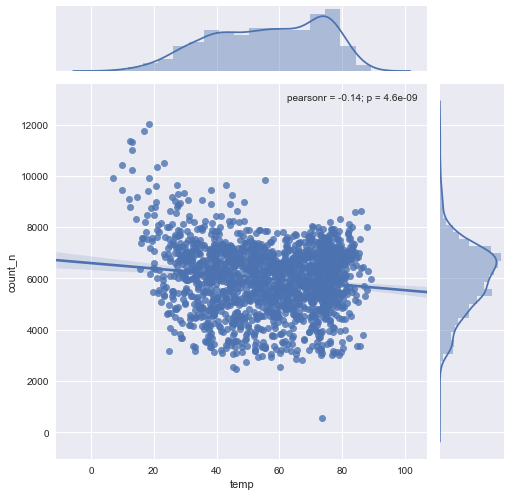

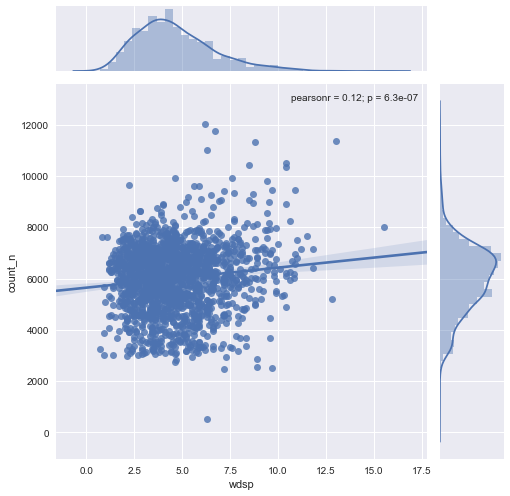

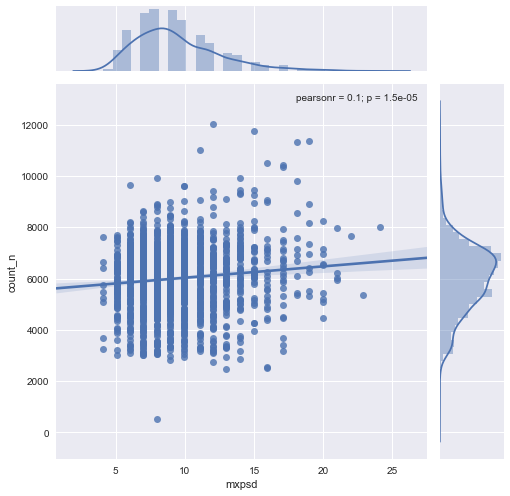

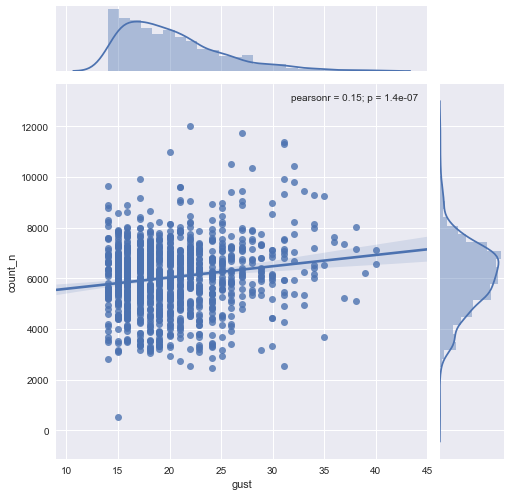

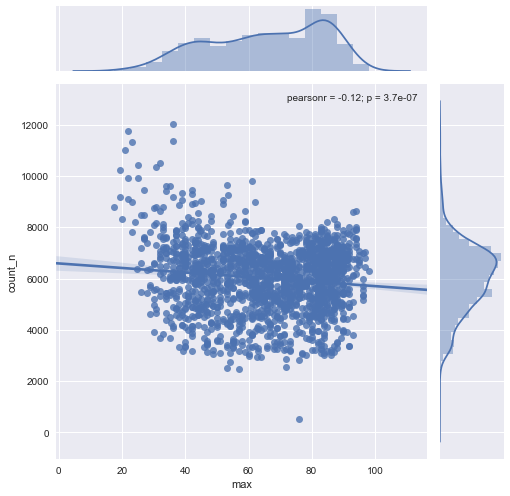

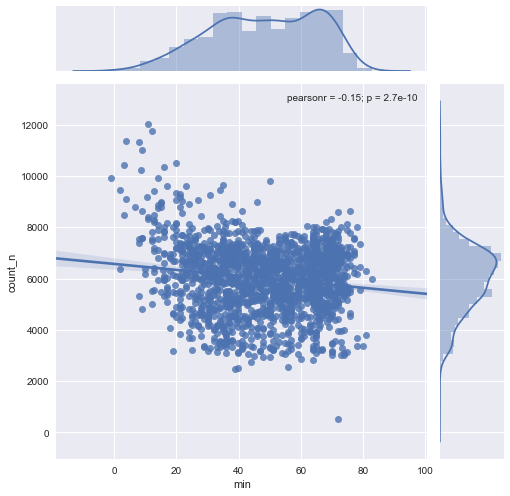

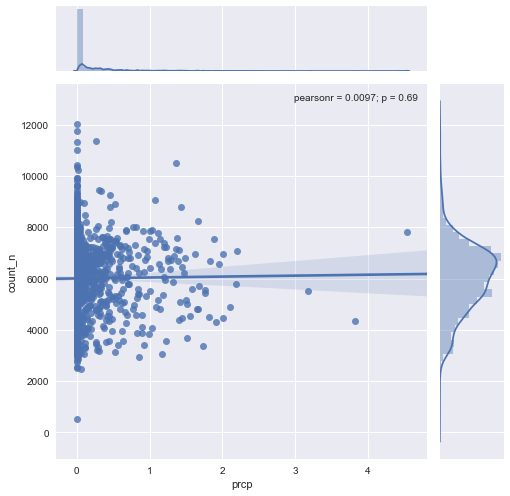

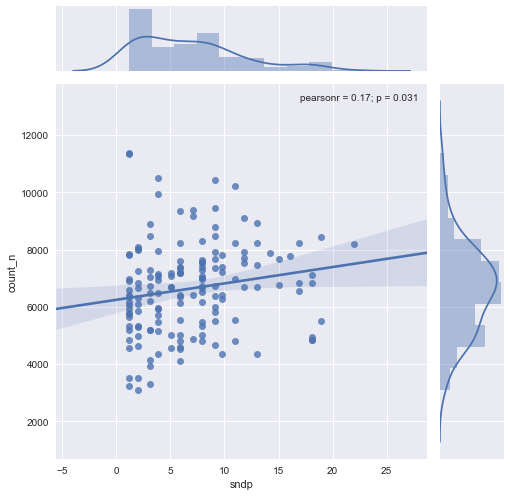

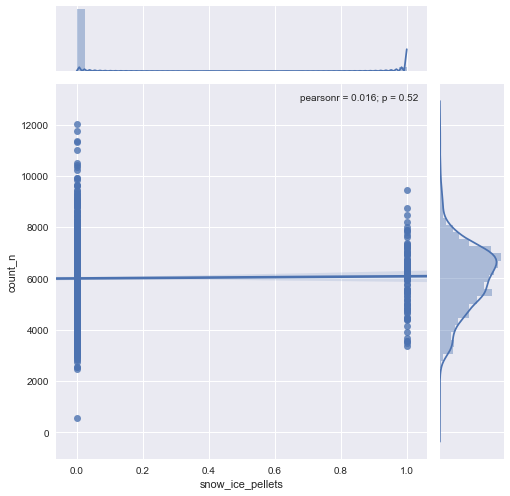

In [80]:
#look at correlation, no extreme obvious correlations between volume and any one factor
for i in columns:

    test = weather_counts[[i, "count_n"]]
    test = test.dropna()
    sns.jointplot(i, "count_n", data=test, kind="reg", size=7)


## now work on answering the question: can we predict 311 service request volume based on weather.

In [81]:
#looking at tutorial and work of fellow data jammer as a start
#https://github.com/facebookincubator/prophet/blob/v0.2/notebooks/seasonality_and_holiday_effects.ipynb
#https://github.com/mattiaf/311NYC/blob/master/PredictVolume/predict_volume.ipynb
#https://facebookincubator.github.io/prophet/docs/quick_start.html#python-api

In [83]:
dfdaycounts.head()

,created_date,count_n
1022,2010-01-01,2906
179,2010-01-02,3857
2619,2010-01-03,5609
1138,2010-01-04,9315
1218,2010-01-05,8299


In [87]:

dfdaycounts.columns=['ds','y']

In [90]:
#generate features. can go back and include complaint type.

m = Prophet()
m.fit(dfdaycounts)

future = m.make_future_dataframe(periods=0)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2818,2017-09-19,7415.724350,6263.218953,8390.328205
2819,2017-09-20,7297.150153,6251.876939,8370.017455
2820,2017-09-21,7098.915819,6007.423238,8095.512917
2821,2017-09-22,6798.740142,5690.236800,7880.029712
2822,2017-09-23,5177.808509,4127.917840,6259.459724


In [91]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-01-01,5620.659539,5620.659539,5620.659539,4635.268016,6650.811121,-6.922430,-6.922430,-6.922430,-6.922430,-6.922430,-6.922430,241.856403,241.856403,241.856403,-248.778832,-248.778832,-248.778832,5613.737110
1,2010-01-02,5619.858767,5619.858767,5619.858767,2999.360809,5098.904615,-1560.779967,-1560.779967,-1560.779967,-1560.779967,-1560.779967,-1560.779967,-1363.950141,-1363.950141,-1363.950141,-196.829826,-196.829826,-196.829826,4059.078801
2,2010-01-03,5619.057995,5619.057995,5619.057995,2674.189562,4785.319323,-1809.341250,-1809.341250,-1809.341250,-1809.341250,-1809.341250,-1809.341250,-1670.376644,-1670.376644,-1670.376644,-138.964607,-138.964607,-138.964607,3809.716745
3,2010-01-04,5618.257223,5618.257223,5618.257223,5186.136756,7320.593904,631.634178,631.634178,631.634178,631.634178,631.634178,631.634178,707.867185,707.867185,707.867185,-76.233006,-76.233006,-76.233006,6249.891401
4,2010-01-05,5617.456450,5617.456450,5617.456450,5310.124334,7449.133683,824.394191,824.394191,824.394191,824.394191,824.394191,824.394191,834.171929,834.171929,834.171929,-9.777738,-9.777738,-9.777738,6441.850641


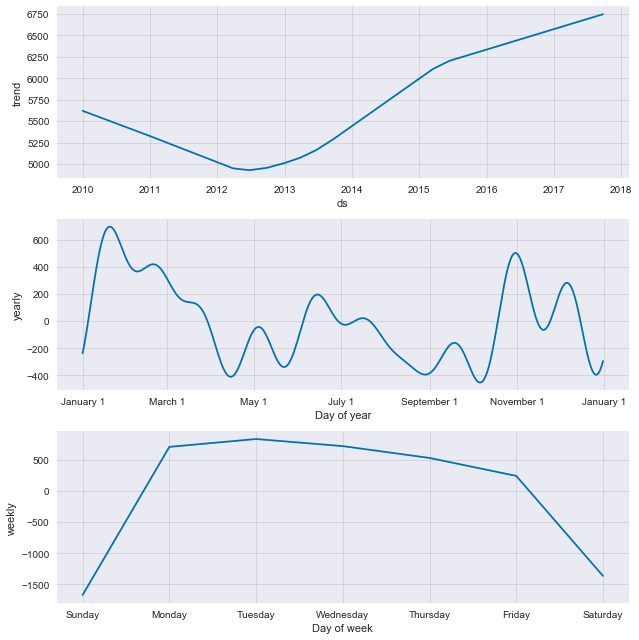

In [93]:

m.plot_components(forecast);

In [100]:
# generate future dates to predict
future = m.make_future_dataframe(periods=365)
future.tail()


,ds
3183,2018-09-19
3184,2018-09-20
3185,2018-09-21
3186,2018-09-22
3187,2018-09-23


In [98]:
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3183,2018-09-19,7540.423253,6520.139001,8534.868453
3184,2018-09-20,7346.763199,6374.470564,8525.576949
3185,2018-09-21,7051.038168,6007.596042,8179.150449
3186,2018-09-22,5434.297471,4395.791201,6581.208338
3187,2018-09-23,5113.549567,4030.560125,6228.297978


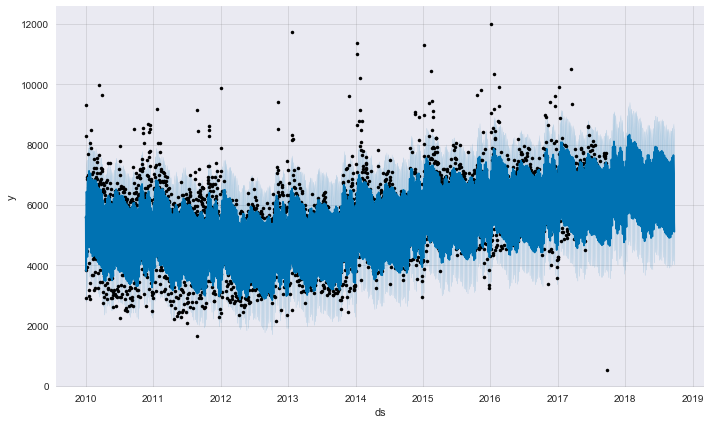

In [101]:
#blue is prediction
m.plot(forecast2);

In [112]:

joined_df = forecast.merge(dfdaycounts, on='ds', how = 'left')

In [113]:
joined_df[['ds','yhat', 'y']].head()


,ds,yhat,y
0,2010-01-01,5613.737110,2906
1,2010-01-02,4059.078801,3857
2,2010-01-03,3809.716745,5609
3,2010-01-04,6249.891401,9315
4,2010-01-05,6441.850641,8299


In [117]:
from sklearn.metrics import r2_score
r2_score(joined_df.y, joined_df.yhat)

0.67389715423973739

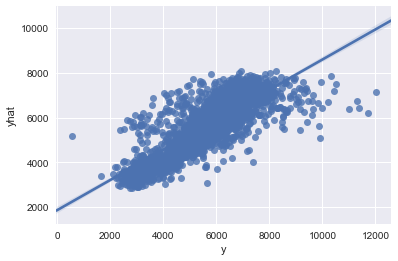

In [125]:
sns.regplot(x = joined_df.y, y = joined_df.yhat)

In [127]:
#generate features
weather_counts.head()

,created_date,count_n,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
0,2016-01-05,12012,18.4,6.2,12.0,22.0,36.0,10.9,0.00,NaN,0.0
1,2013-01-24,11732,16.8,6.7,15.0,27.0,21.9,12.0,0.00,NaN,0.0
2,2014-01-07,11367,12.3,13.0,19.0,31.1,36.0,3.9,0.27,1.2,0.0
3,2015-01-08,11318,13.0,8.8,18.1,31.1,23.0,8.1,0.00,1.2,0.0
4,2014-01-08,10998,12.9,6.3,11.1,20.0,21.0,9.0,0.00,NaN,0.0


In [128]:
len(weather_counts)

1727

In [130]:
weather_counts.isnull().sum() 
# for this station, snow depth measures are not good! mostly missing! 
#not a ton of daya. under 5 years.
#can get data for other new york city weather stations to fill in the gap after first trial.
#for now remove gust and snow depth as features since missing a lot

created_date           0
count_n                0
temp                   0
wdsp                  18
mxpsd                 18
gust                 574
max                    0
min                    0
prcp                   0
sndp                1573
snow_ice_pellets       0
dtype: int64

In [134]:
weather_counts2 = weather_counts.drop(['sndp', 'gust'],  axis=1)

In [135]:
weather_counts2.dropna(inplace = True)

In [136]:
#generating a few more features
weather_counts2['dayofweek'] = weather_counts2['created_date'].dt.dayofweek
weather_counts2['month'] = weather_counts2['created_date'].dt.month
weather_counts2['year'] = weather_counts2['created_date'].dt.year

In [137]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [140]:
min(weather_counts2['created_date'])

Timestamp('2013-01-01 00:00:00')

In [143]:
cal = calendar()
holidays = cal.holidays(start=min(weather_counts2['created_date']), end=max(weather_counts2['created_date']))

In [145]:
holidays

DatetimeIndex(['2013-01-01', '2013-01-21', '2013-02-18', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11',
               '2013-11-28', '2013-12-25', '2014-01-01', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25',
               '2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04'],
              dtype='datetime64[ns]', freq=None)

In [146]:
def get_holidate(x):
    if x in holidays:
        return 1
    else:
        return 0
    
weather_counts2['holiday'] = [get_holidate(x) for x in weather_counts2['created_date']]

In [149]:
#will add other features from the 311 data in the future!!
#try several models
from sklearn.ensemble import RandomForestRegressor


In [150]:
weather_counts2.head()

,created_date,count_n,temp,wdsp,mxpsd,max,min,prcp,snow_ice_pellets,dayofweek,month,year,holiday
0,2016-01-05,12012,18.4,6.2,12.0,36.0,10.9,0.00,0.0,1,1,2016,0
1,2013-01-24,11732,16.8,6.7,15.0,21.9,12.0,0.00,0.0,3,1,2013,0
2,2014-01-07,11367,12.3,13.0,19.0,36.0,3.9,0.27,0.0,1,1,2014,0
3,2015-01-08,11318,13.0,8.8,18.1,23.0,8.1,0.00,0.0,3,1,2015,0
4,2014-01-08,10998,12.9,6.3,11.1,21.0,9.0,0.00,0.0,2,1,2014,0


In [151]:
y = weather_counts2['count_n']
xvar = weather_counts2.drop(['count_n'],  axis=1)

In [158]:
xvar = weather_counts2.drop(['created_date'],  axis=1)

In [184]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xvar, y, test_size=0.33, random_state=42)

In [195]:
#need to research parameters to choose from
regr = RandomForestRegressor()

In [196]:
regr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [197]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [198]:
y_pred=regr.predict(X_test)

In [199]:
dfpreds = pd.DataFrame()

In [200]:
dfpreds['y_test'] = y_test

In [201]:
dfpreds['y_pred'] = y_pred

In [202]:
dfpreds['diff'] = abs(dfpreds['y_test']-dfpreds['y_pred'])

In [203]:
dfpreds.sort_values(['diff'], ascending = 0).head()

,y_test,y_pred,diff
1718,2955,3042.7,87.7
1719,2940,3024.9,84.9
1717,2963,3031.5,68.5
34,8776,8728.6,47.4
1721,2835,2787.9,47.1


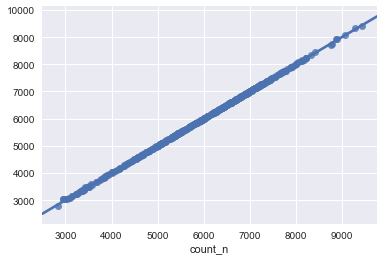

In [204]:
#plot predictions against truth
sns.regplot(x = y_test, y = y_pred) #this seems impossible!!

In [ ]:
#re-do also pick data out of sample from 2010-2013 using a different weather station in NYC